In [1]:
import torch
from torch import nn
import torchvision
from torchvision import transforms

from utils import *
from train import *

d:\Machine Learning\pytorch\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [2]:
BATCH_SIZE = 64
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_dataloader, test_dataloader, class_names = dataloader(train_dataset, test_dataset, BATCH_SIZE)

In [4]:
# new conv
def conv(ni, nf, ks=3, stride=2, act=nn.ReLU, norm=None, bias=None):
    if bias is None: bias = not isinstance(norm, (nn.BatchNorm1d,nn.BatchNorm2d,nn.BatchNorm3d))
    layers = [nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2, bias=bias)]
    if norm: layers.append(norm(nf))
    if act: layers.append(act())
    return nn.Sequential(*layers)

def get_model(act=nn.ReLU, nfs=(8,16,32,64,128), norm=nn.BatchNorm2d):
    layers = [conv(1, 8, stride=1, act=act, norm=norm)]
    layers += [conv(nfs[i], nfs[i+1], act=act, norm=norm) for i in range(len(nfs)-1)]
    return nn.Sequential(
        *layers, 
        conv(nfs[-1], 10, act=None, norm=norm, bias=True), 
        nn.Flatten()
    )

model = get_model(norm=nn.BatchNorm2d)

In [5]:
lr = 6e-2
epochs = 5
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(params=model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr, total_steps=epochs*len(train_dataloader))

Progress:   0%|          | 0/15 [00:00<?, ?it/s]

Epoch	Mode	Loss	Accuracy
0	train	0.4822	0.8600
0	test	0.3724	0.8738
1	train	0.3132	0.8940
1	test	0.2936	0.8963
2	train	0.2659	0.9088
2	test	0.2990	0.8910
3	train	0.2358	0.9179
3	test	0.2529	0.9121
4	train	0.2102	0.9262
4	test	0.2416	0.9135
5	train	0.1914	0.9319
5	test	0.2596	0.9083
6	train	0.1735	0.9394
6	test	0.2282	0.9197
7	train	0.1566	0.9449
7	test	0.2658	0.9122
8	train	0.1427	0.9500
8	test	0.2329	0.9193
9	train	0.1294	0.9539
9	test	0.2537	0.9176
10	train	0.1150	0.9595
10	test	0.2500	0.9209
11	train	0.1076	0.9624
11	test	0.2511	0.9172
12	train	0.0961	0.9657
12	test	0.2784	0.9122
13	train	0.0908	0.9685
13	test	0.2836	0.9167
14	train	0.0805	0.9728
14	test	0.2759	0.9195


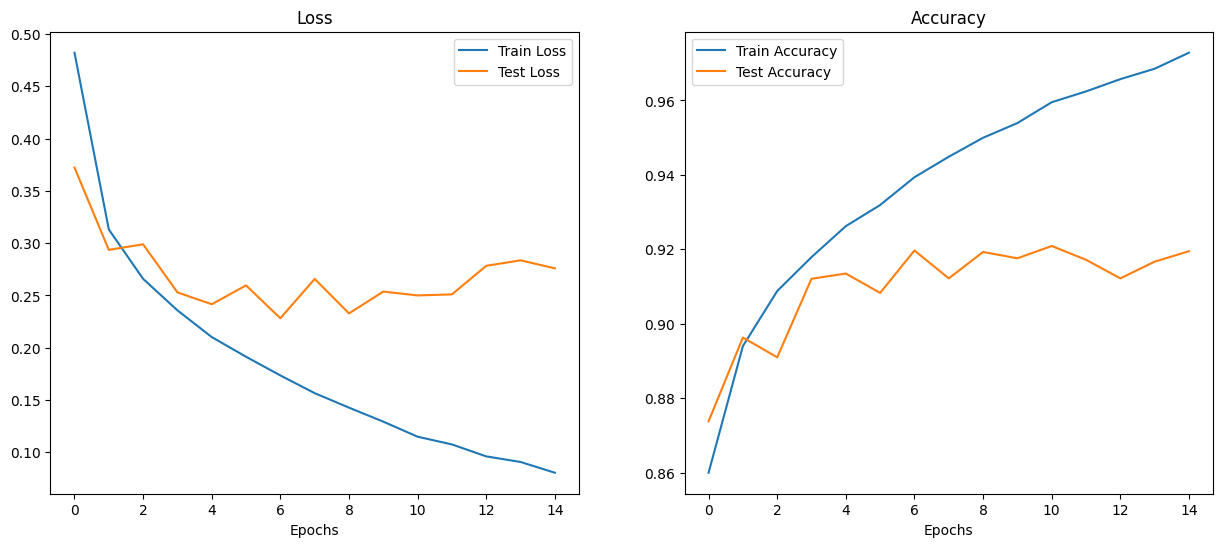

In [6]:
learn = Learner(model=model, train_dataloader=train_dataloader, test_dataloader=test_dataloader, loss_fn=loss_fn, optimizer=optimizer, scheduler=scheduler, device=device)
learn.fit(15)